# Transformers for Stock Price Prediction



In [ ]:
!pip install yahoofinancials
from yahoofinancials import YahooFinancials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

#For reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Some functions to help out with
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e

#Scaled Exponentially-Regularized Linear Unit to try out - if anyone can make this work, let me know.

# def serlu(x, lambdaa=1.07862, alphaa=2.90427):
#     result = tf.cond(x >= 0, lambda: tf.math.multiply(lambdaa, x), lambda: tf.math.multiply(lambdaa, alphaa, x, tf.exp(x)))
#     return result


<ipython-input-1-3bb9805d5ece>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Get the Data

In [ ]:
# # Choose a stock symbol
symbol_to_fetch = 'MSFT'
# Choose a date range
start_date = '2020-01-01'
end_date = '2024-01-01'
# Get Stock Price Data
stock = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
stock['DateTime'] = stock['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
stock = stock.fillna(method="ffill", axis=0)
stock = stock.fillna(method="bfill", axis=0)
stock = stock.set_index('DateTime')
# stock['return'] = stock['Close'].pct_change(1)
# for i in stock.index[1:]:
#     if (stock['return'].iloc[i] > 0 and stock['return'].iloc[i-1] < 0) or (stock['return'].iloc[i] < 0 and stock['return'].iloc[i-1] > 0):
#         stock['reversal'].iloc[i] = 1
#     else:
#         stock['reversal'].iloc[i] = 0
stock['Symbol'] = symbol_to_fetch
stock.tail()
#save a copy for later testing
original_stock = stock
original_symbol = symbol_to_fetch

stock['Close'].tail()

DateTime
2023-12-22 14:30:00    373.888580
2023-12-26 14:30:00    373.968445
2023-12-27 14:30:00    373.379547
2023-12-28 14:30:00    374.587280
2023-12-29 14:30:00    375.345886
Name: Close, dtype: float64

In [ ]:
# Choose a stock symbol
# Choose a date range
start_date = str(datetime(2017, 1, 1).date())
end_date = str(datetime(2021, 2, 18).date())
# end_date = datetime.now().strftime('%Y-%m-%d')

In [ ]:
# We have chosen the target as 'Close' attribute for prices. Let's see what it looks like
target = 'Close' # this is accessed by .iloc[:,3:4].values below
train_start_date = start_date
train_end_date = '2022-10-31'
test_start_date = '2022-10-31'
training_set = stock[train_start_date:train_end_date].iloc[:,3:4].values
test_set = stock[test_start_date:].iloc[:,3:4].values

test_set_return = stock[test_start_date:].iloc[:,3:4].pct_change().values
#log_return_test = np.log(test_set_return)

print(training_set.shape)
print(test_set.shape)

(714, 1)
(293, 1)


In [ ]:
# #let's try adding multiple stocks in the training set... Like everything in the SPY holdings to see if that improves our target
# connection = sqlite3.connect('../input/spy-stocks/spy.db')
# connection.row_factory = sqlite3.Row
# cursor = connection.cursor()
# cursor.execute("""
#     SELECT symbol FROM stocks
# """)
# rows = cursor.fetchall()
# for row in rows:
#     try:
#         symbol = row['symbol']
#         print (symbol)
#         symbol_to_fetch = symbol
#         stock = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
#         stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
#         stock['DateTime'] = stock['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
#         stock = stock.fillna(method="ffill", axis=0)
#         stock = stock.fillna(method="bfill", axis=0)
#         stock = stock.set_index('DateTime')
#         new_training_set = stock[train_start_date:train_end_date].iloc[:,3:4].values
#         frames = [training_set, new_training_set]
#         training_set = np.concatenate(frames, axis = 0)
#     except:
#         continue
# print(training_set.shape)
# # This works best with a TPU and trains very fast so only around 10 epochs needed due to the 1.8 million sample.
# # Also it is possible to sort by sector - just add (WHERE sector = 'Information Technology') under
# # the SELECT line.


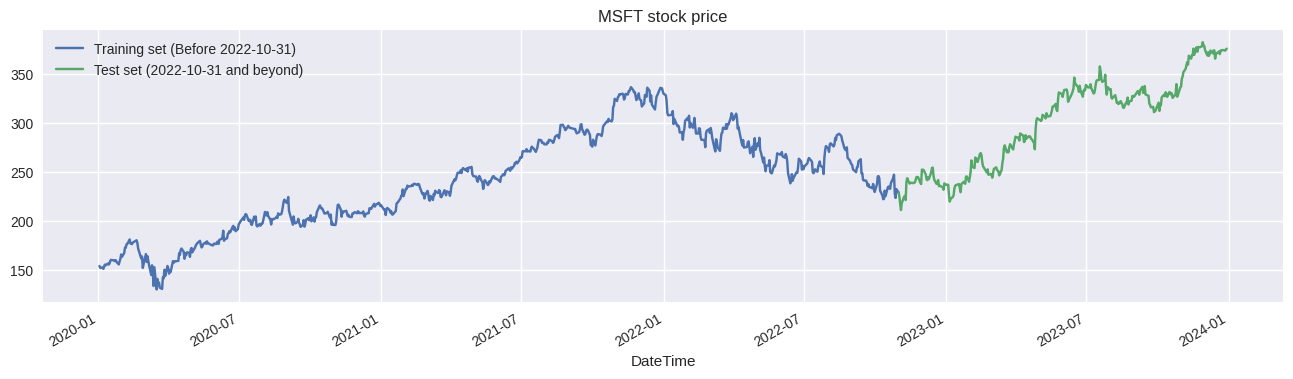

In [ ]:
stock[target][train_start_date:train_end_date].plot(figsize=(16,4),legend=True)
stock[target][test_start_date:].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set (Before {train_end_date})',f'Test set ({test_start_date} and beyond)'])
plt.title(f'{symbol_to_fetch} stock price')
plt.show()

In [ ]:
# Scaling the training set - I've tried it without scaling and results are very poor.
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)


In [ ]:
timesteps = 8
# First, we create data sets where each sample has with 8 timesteps and 1 output
# So for each element of training set, we have 8 previous training set elements
x_train = []
y_train = []
for i in range(timesteps,training_set.shape[0]):
    x_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

# Notice how the first y_train value becomes the last X_train value for the next sample

[0.11610375 0.10675181 0.10866894 0.10188898 0.11362553 0.12297754
 0.11947032 0.12854172] 0.12316454461464621
[0.10675181 0.10866894 0.10188898 0.11362553 0.12297754 0.11947032
 0.12854172 0.12316454] 0.12807424938181766


### The choice of the number of timesteps is the first thing worth noting. This is also true with RNNs, but with transformers - the optimum choice is often much lower. Three stocks are shown below. With RNNs the number ranges much higher. For ConvLSTMs the optimum is usually between 40-90 timesteps, with transformers it is usually under 10.
![Rmse_by_timestep.png](attachment:ad1bbf60-ca20-47f2-8870-24c056ff7f44.png)

In [ ]:
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(706, 8) (706,)
(706, 8, 1) (706,)


In [ ]:
print(x_train.shape, y_train.shape)
# Interestingly - randomly arranging the samples works well, since we are using validation_split = 0.2, (rather then validation_data = )
# It is worth looking into whether using a K-fold would work better - if so would not use random permutation.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

(706, 8, 1) (706,)


# Build the model

### Our model processes a tensor of shape [batch size, sequence length, features], where sequence length is the number of time steps in your sample and features is the number of elements you are trying to predict. If we are only trying to predict one thing, such as closing price - then features is 1. When it comes to describing tensor shapes, I am going to refer to batch size as "#samples" so as not to confuse it with batch_size when fitting the model.

### Fortunately, with recurrent neural nets (such as LSTMs) for timeseries analysis, the inputs [#samples, timesteps, features] are compatible with transformers!
#### The image below is for a single transformer encoder block. For our purposes, the embedding is removed and limited to only to a LayerNormalization layer (which does work better than a BatchNormalization layer). The positional embedding is an option, but frankly - I have tried three diferent time2vec implementations and although the code works, the results are worse (If you can implement a time2vec function which actually improves the rmse score then please share with me). The multi-head attention is already coded for in keras. The feed forward part can be almost anything. We will use a Conv1D layer(because results are good) but you could get away with almost anything, dense layers, another LSTM, whatever you want. You could also stick an LSTM in the embedding layer - it works, if your return_sequences = True, it just give worse results.

<center>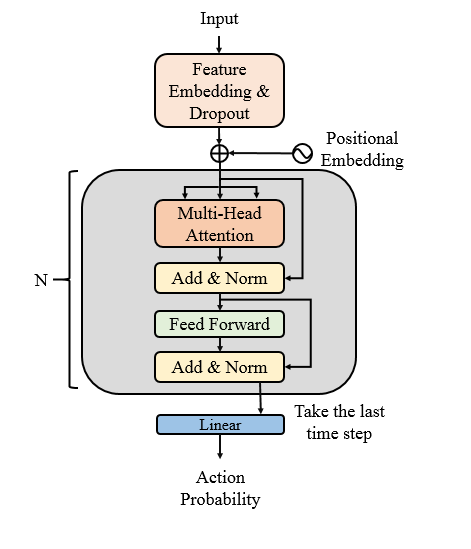</center>

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work.
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

### The main part of our model is now complete.
### We can stack multiple of those transformer_encoder blocks and we can also proceed to add the final Multi-Layer Perceptron/ DNN head.

### Apart from a stack of Dense layers, we need to reduce the output tensor of the TransformerEncoder part of our model down to a vector of features for each data point in the current batch. A pooling layer like GlobalAveragePooling1D layer will do this.
GlobalAveragePooling1D input shape is [#samples, timesteps, features] (if channels_first format is chosen), its default output is [#samples, timesteps].

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)


### Another note - the activation function above makes a difference, elu is best : elu > selu > tanh > relu > gelu > swish. I am curious if serlu would out perform them but I can't figure out how to add the custom activation function.

In [ ]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# This learning rate scheduler is also from Mr. Theodoros Ntakouris' articla at https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3
# I am definetely a fan.

In [ ]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [ ]:
model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
#model.summary()


history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=20,
    callbacks=callbacks,
)

Epoch 1/100
29/29 [==============================] - 33s 232ms/step - loss: 0.5736 - mean_squared_error: 0.5736 - val_loss: 0.6158 - val_mean_squared_error: 0.6158 - lr: 1.0000e-06
Epoch 2/100
29/29 [==============================] - 5s 176ms/step - loss: 0.4665 - mean_squared_error: 0.4665 - val_loss: 0.4075 - val_mean_squared_error: 0.4075 - lr: 3.4300e-05
Epoch 3/100
29/29 [==============================] - 5s 189ms/step - loss: 0.3149 - mean_squared_error: 0.3149 - val_loss: 0.3083 - val_mean_squared_error: 0.3083 - lr: 6.7600e-05
Epoch 4/100
29/29 [==============================] - 5s 158ms/step - loss: 0.2422 - mean_squared_error: 0.2422 - val_loss: 0.1859 - val_mean_squared_error: 0.1859 - lr: 1.0090e-04
Epoch 5/100
29/29 [==============================] - 5s 163ms/step - loss: 0.0968 - mean_squared_error: 0.0968 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - lr: 1.3420e-04
Epoch 6/100
29/29 [==============================] - 6s 215ms/step - loss: 0.0370 - mean_squared_er

# Evaluate model

10/10 [==============================] - 1s 84ms/step
[373.37954712] [374.58728027] [375.34588623]
[373.96844482] [373.37954712] [374.58728027]
[372.0213]


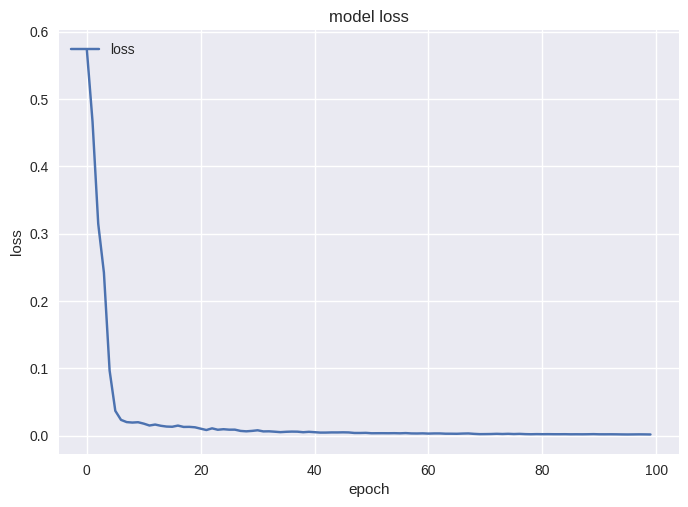

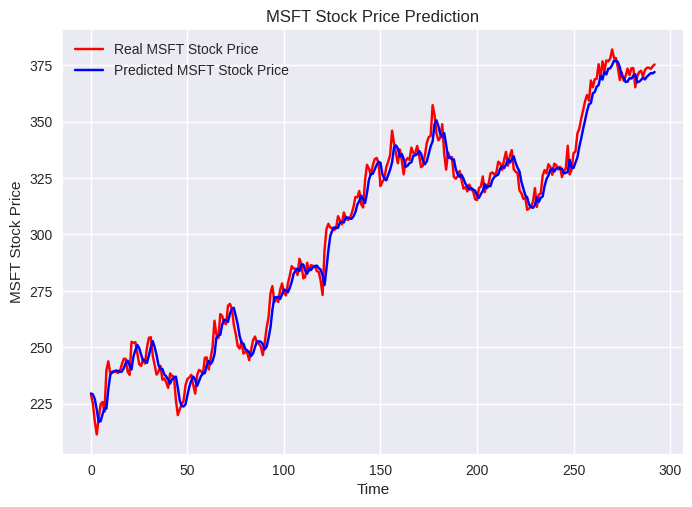

The root mean squared error is 5.455008573787148.


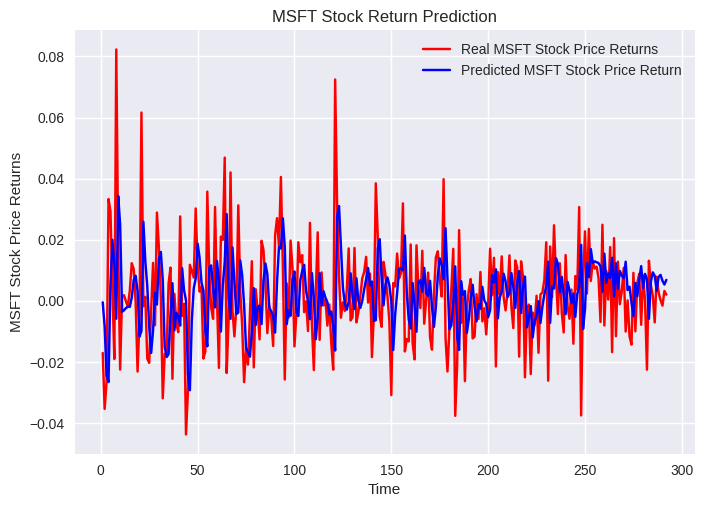

The root mean squared error is 0.02029571221196097.


0.02029571221196097

In [ ]:
# First we have to frontload the test data before the inital values of our test_set

dataset_total = pd.concat((original_stock[target][:train_end_date],original_stock[target][test_start_date:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1) #The shift function is defined early in the notebook
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price # This is the error on the same day
#Before we can calculate the predicted return we have to shift the test_set to the day before so we use the shifted_test_set
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

plot_predictions(test_set,predicted_stock_price,original_symbol)
return_rmse(test_set,predicted_stock_price)

plot_return_predictions(test_set_return,predicted_return,original_symbol)
return_rmse(test_set_return[1:], predicted_return[1:])


# Points of Consideration

### 1. The number of timesteps is a critical factor and the optimal number will vary for each stock. But as a whole the optimal number is lower than for RNNs.
### 2. Unlike RNN's adding Time2Vec embedding does not improve results.
### 3. elu is the best activation for the final DNN/MLP "classification head".
### 4. Also - I know that what really counts is predicting returns. However if I use stock['return'] instead of stock['Close'] I get vanishing gradients. If anyone can help me solve THAT problem I would greatly appreciate it.
### 5. In the Price and Return graphs above - there is always a lag, that is expected - but unfortunately it is also very unprofitable. If one ever hopes to apply this - one has to be able to minimize losses, by predicting price reversals. I have tried to apply the same model to predict whether there is a reversal and it works ! but only 50.000 % of the time.

# Trading Startegy



In [ ]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    'Test Set': test_set.flatten(),  # Flatten to ensure it's 1D
    'Real Stock Returns': test_set_return.flatten(),  # Flatten to ensure it's 1D
    'Predicted Stock Prices': predicted_stock_price.flatten()  # Flatten to ensure it's 1D
})

df['Real Stock Returns'] = df['Real Stock Returns'].shift(-1)


# Display DataFrame
#print(df)

In [ ]:
# Add 'Position' column based on condition
df['Position'] = df.apply(lambda row: 1 if row['Predicted Stock Prices'] > row['Test Set'] else -1, axis=1)

# Calculate PnL based on Position
df['PnL'] = df['Position'] * (df['Test Set'].shift(-1) - df['Test Set'])

# Calculate cumulative PnL
df['Cumulative PnL'] = df['PnL'].cumsum()
df=df[:-1]


<ipython-input-20-77f76ecd2e02>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cumulative PnL'] = df['Cumulative PnL'] + starting_balance
<ipython-input-20-77f76ecd2e02>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Daily Return'] = df['Cumulative PnL'].pct_change()


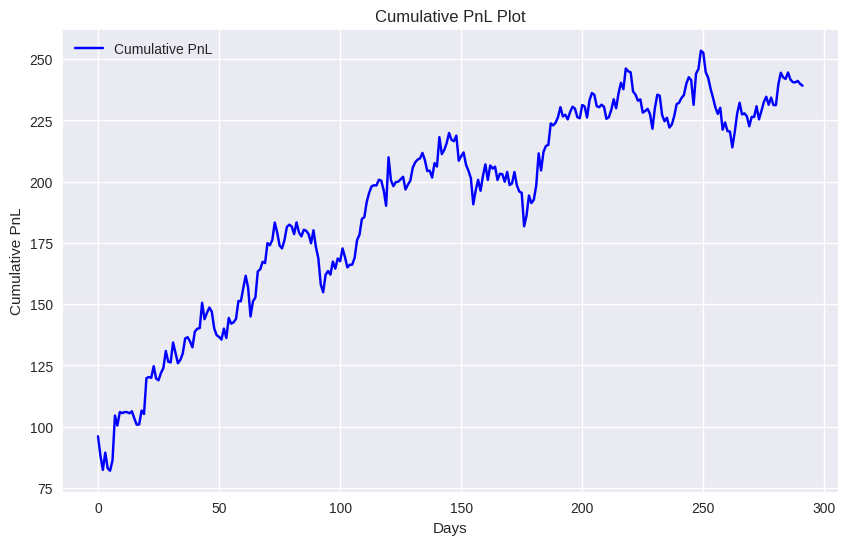

Percentage Return:139.191%
Annualized Volatility: 48.282%
Annualized Sharpe Ratio: 1.8728859788763095


In [ ]:
# Calculate starting balance
starting_balance = 100

# Make cumulative PnL start from 100
df['Cumulative PnL'] = df['Cumulative PnL'] + starting_balance

# Calculate daily returns
df['Daily Return'] = df['Cumulative PnL'].pct_change()

# Calculate percentage return
percentage_return = (df['Cumulative PnL'].iloc[-1] / 100) -1

# Calculate annualized volatility
annualized_volatility = np.std(df['Daily Return']) * np.sqrt(252)

# Calculate annualized Sharpe ratio
daily_rf_rate = 0  # Assuming risk-free rate is zero
daily_sharpe_ratio = (np.mean(df['Daily Return']) - daily_rf_rate) / np.std(df['Daily Return'])
annualized_sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)

# Plot Cumulative PnL
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(df.index, df['Cumulative PnL'], color='blue', label='Cumulative PnL')
plt.title('Cumulative PnL Plot')
plt.xlabel('Days')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.show()

# Print results
# Print results
print("Percentage Return:{:.3f}%".format(percentage_return*100))
print("Annualized Volatility: {:.3f}%".format(annualized_volatility*100))
print("Annualized Sharpe Ratio:", annualized_sharpe_ratio)